# 数据导入以及处理

数据来自kaggle [https://www.kaggle.com/henslersoftware/19560-indian-takeaway-orders](https://www.kaggle.com/henslersoftware/19560-indian-takeaway-orders)

## 导入库

In [4]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="white")
sns.set(style="whitegrid", color_codes=True)

import warnings

warnings.simplefilter("ignore")

## 读取数据并作简单的了解

In [5]:
data = pd.read_csv("restaurant-1-orders.csv")
data

,Order Number,Order Date,Item Name,Quantity,Product Price,Total products
0,16118,03/08/2019 20:25,Plain Papadum,2,0.80,6
1,16118,03/08/2019 20:25,King Prawn Balti,1,12.95,6
2,16118,03/08/2019 20:25,Garlic Naan,1,2.95,6
3,16118,03/08/2019 20:25,Mushroom Rice,1,3.95,6
4,16118,03/08/2019 20:25,Paneer Tikka Masala,1,8.95,6
...,...,...,...,...,...,...
74813,2518,18/05/2016 18:53,House Red wine 75cl,2,17.95,7
74814,2503,14/05/2016 19:28,House Red wine 75cl,2,17.95,6
74815,2467,10/05/2016 13:18,House Red wine 75cl,2,17.95,9
74816,2249,07/04/2016 19:04,House white wine 75cl,1,17.95,6


In [6]:
data.shape

(74818, 6)

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74818 entries, 0 to 74817
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Order Number    74818 non-null  int64  
 1   Order Date      74818 non-null  object 
 2   Item Name       74818 non-null  object 
 3   Quantity        74818 non-null  int64  
 4   Product Price   74818 non-null  float64
 5   Total products  74818 non-null  int64  
dtypes: float64(1), int64(3), object(2)
memory usage: 3.4+ MB


In [8]:
data.describe()

,Order Number,Quantity,Product Price,Total products
count,74818.000000,74818.000000,74818.000000,74818.000000
mean,9115.638162,1.243564,5.286492,6.931434
std,4052.210452,0.798207,3.338221,3.954832
min,630.000000,1.000000,0.500000,1.000000
25%,5590.000000,1.000000,2.950000,5.000000
50%,9103.000000,1.000000,3.950000,6.000000
75%,12630.000000,1.000000,8.950000,8.000000
max,16118.000000,51.000000,17.950000,60.000000


In [9]:
data.isnull().sum()

Order Number      0
Order Date        0
Item Name         0
Quantity          0
Product Price     0
Total products    0
dtype: int64

发现没有缺失值，说明kaggle上面的数据集质量还是不错的

## 数据处理

### 将日期转化为datetime64类型

In [10]:
data["Order Date"] = pd.to_datetime(data["Order Date"])

### 计算总价格

总价格为$ Product Price * Quantity $

In [11]:
data["Total Price"] = data["Product Price"] * data["Quantity"]
data

,Order Number,Order Date,Item Name,Quantity,Product Price,Total products,Total Price
0,16118,2019-03-08 20:25:00,Plain Papadum,2,0.80,6,1.60
1,16118,2019-03-08 20:25:00,King Prawn Balti,1,12.95,6,12.95
2,16118,2019-03-08 20:25:00,Garlic Naan,1,2.95,6,2.95
3,16118,2019-03-08 20:25:00,Mushroom Rice,1,3.95,6,3.95
4,16118,2019-03-08 20:25:00,Paneer Tikka Masala,1,8.95,6,8.95
...,...,...,...,...,...,...,...
74813,2518,2016-05-18 18:53:00,House Red wine 75cl,2,17.95,7,35.90
74814,2503,2016-05-14 19:28:00,House Red wine 75cl,2,17.95,6,35.90
74815,2467,2016-10-05 13:18:00,House Red wine 75cl,2,17.95,9,35.90
74816,2249,2016-07-04 19:04:00,House white wine 75cl,1,17.95,6,17.95


### 选取需要分析的数据

In [12]:
grouper = pd.Grouper(key="Order Date", freq="Y")
data.groupby(grouper).sum().reset_index()

,Order Date,Order Number,Quantity,Product Price,Total products,Total Price
0,2015-12-31,85035,80,353.10,312,412.50
1,2016-12-31,34487972,13496,57205.25,78250,63978.80
2,2017-12-31,126190039,26112,110157.85,142369,126484.50
3,2018-12-31,263228568,31239,134138.45,180308,150094.70
4,2019-12-31,258022202,22114,93670.10,117357,105546.95


观察发现2015年的数据并不完整，因此去除不作为分析的对象。

In [13]:
data = data[data["Order Date"].dt.year != 2015]

### 合并订单

由于相同的订单并不在同一行，因此需要合并这些订单，并计算出总销售额

In [14]:
data = data.sort_values("Order Number")

In [15]:
order_price = data.groupby("Order Number")[["Total Price",
                                            "Quantity"]].sum().reset_index()
temp_data = data.drop_duplicates(subset=["Order Number"],
                                 keep="first").reset_index()
order_price["Order Date"] = temp_data["Order Date"]
order_price

,Order Number,Total Price,Quantity,Order Date
0,1784,46.60,8,2016-07-03 11:18:00
1,1785,22.75,5,2016-07-03 16:59:00
2,1786,21.75,5,2016-07-03 17:04:00
3,1787,8.95,1,2016-07-03 17:09:00
4,1788,46.60,8,2016-08-03 11:45:00
...,...,...,...,...
13363,16114,17.85,3,2019-03-08 19:44:00
13364,16115,23.60,7,2019-03-08 20:01:00
13365,16116,33.75,5,2019-03-08 20:09:00
13366,16117,32.30,7,2019-03-08 20:17:00


# 数据分析

## 总的价格分布

In [16]:
final_ = [order_price["Total Price"].min()] + list(np.linspace(
    10, 100, 10)) + [order_price["Total Price"].max()]
pd.cut(order_price["Total Price"], bins=final_).value_counts().sort_index()

(0.5, 10.0]         250
(10.0, 20.0]       2172
(20.0, 30.0]       4240
(30.0, 40.0]       3498
(40.0, 50.0]       1645
(50.0, 60.0]        777
(60.0, 70.0]        334
(70.0, 80.0]        172
(80.0, 90.0]         89
(90.0, 100.0]        60
(100.0, 1242.0]     100
Name: Total Price, dtype: int64

可以看到价格基本上都在20-40之间，画图更能直观的感受到。

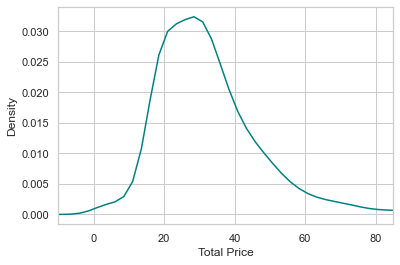

In [17]:
order_price["Total Price"].plot(kind="density", color="teal")
plt.xlabel("Total Price")
plt.xlim(-10, 85)
plt.show()

## 计算每个订单的平均价格

In [18]:
print("每个订单的平均价格为：", order_price["Total Price"].mean())

每个订单的平均价格为： 33.371106373428844


## 年度销售额曲线

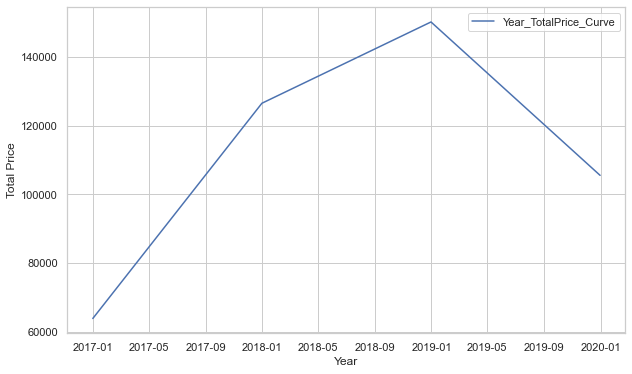

In [41]:
grouper = pd.Grouper(key="Order Date", freq="Y")
Year_Total_Price = data.groupby(grouper).sum().reset_index()
plt.figure(figsize=(10, 6))
plt.plot(Year_Total_Price["Order Date"],
         Year_Total_Price["Total Price"],
         label="Year_TotalPrice_Curve")
plt.xlabel("Year")
plt.ylabel("Total Price")
plt.legend()
plt.show()


可见销售额在2016-2019年都是稳步增长，但在2019年末下降。

## 对比销量前五的产品在不同年的销量

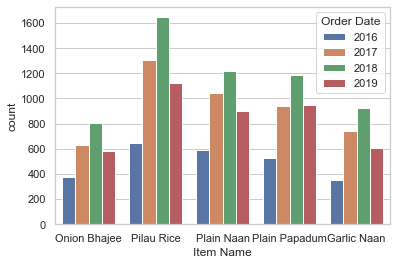

In [20]:
condition = data["Item Name"].value_counts()[:5].index
df = data[data["Item Name"].apply(lambda x: x in condition)]
df["Order Date"] = df["Order Date"].dt.year
sns.countplot(data=df, x="Item Name", hue="Order Date")
plt.show()

可以看出销量基本上在2018年达到了巅峰。Pilau Rice的销量一直最高，这也看出来了吃饭主食是必需品

## 自定义可视化

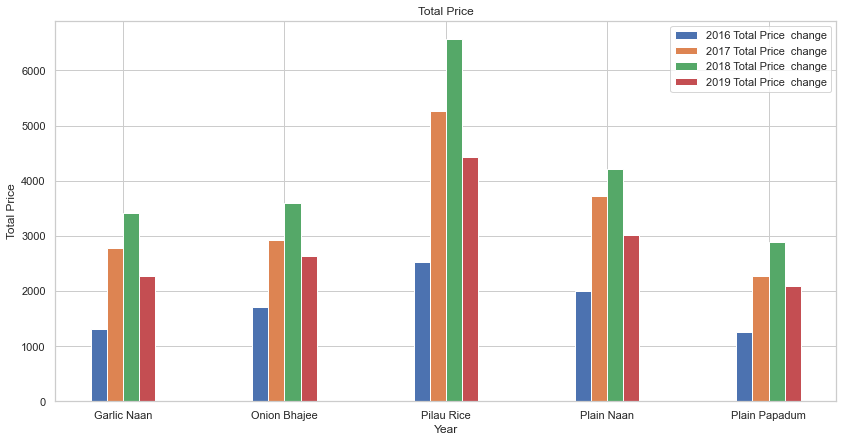

In [44]:
def show_data_by_condition(df: pd.DataFrame, title: str, colname: str="Total Price", method: str="sum"):
    """[summary]

    Args:
        df ([type]): [dataframe]
        title (str): [the title of graph]
        colname (str, optional): [the column name]. Defaults to "Total Price".
        method (str, optional): [the function]. Defaults to "sum".
    """
    def transform(df: pd.DataFrame):
        return df.groupby("Order Date")[colname].agg(method)

    res = df.groupby("Item Name").apply(transform)
    width = 0.1
    plt.figure(figsize=(14, 7))
    for index, column_name in enumerate(res):
        plt.bar(np.arange((len(res.index))) + index * width,
                res[column_name],
                width=width,
                label=str(column_name) + " " + colname + "  change")
    plt.xticks(
        np.arange((len(res.index))) + (width * (len(res.columns) - 1)) / 2,
        res.index)
    plt.title(title)
    plt.xlabel("Year")
    plt.ylabel(title)
    plt.legend()
    plt.show()


# 对比Total Price的变化
show_data_by_condition(df, "Total Price")

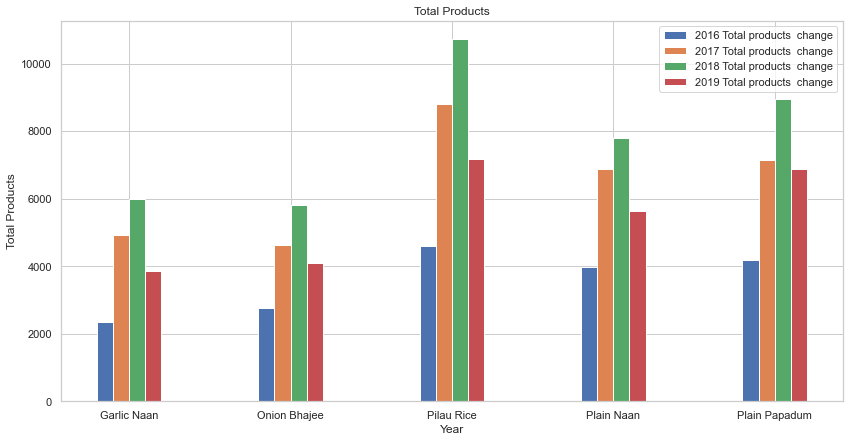

In [22]:
# 总卖出去的产品总数的变化
show_data_by_condition(df,
                       "Total Products",
                       colname="Total products",
                       method="sum")

## 顾客一般都在什么时候下单？

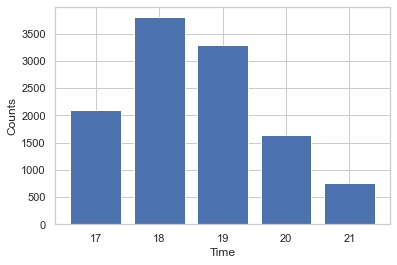

In [23]:
counts = order_price["Order Date"].dt.hour.value_counts()[:5]
plt.bar(counts.index, counts)
plt.xlabel("Time")
plt.ylabel("Counts")
plt.show()

In [24]:
order_price["Order Date"].dt.hour.mean()  # 下单时间的平均值

18.156343506882106

可见顾客一般都是在下午六点左右下单，说明这家饭店一定不是一个早餐店。

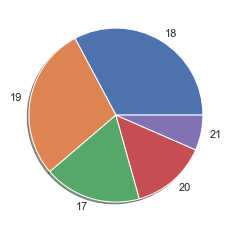

In [25]:
plt.pie(x=counts, labels=counts.index, shadow=True)
plt.show()

用饼图可以看的更加直观

## 下单的总价和时间有没有关系？

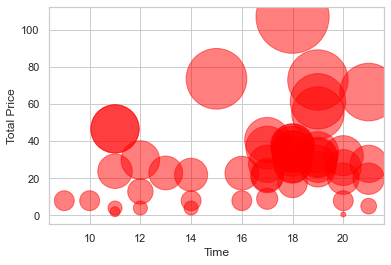

In [42]:
temp_order_data = order_price.copy()
temp_order_data["Order Date"] = order_price["Order Date"].dt.hour
plt.scatter(temp_order_data["Order Date"][:50], temp_order_data["Total Price"][:50],s= temp_order_data["Total Price"][:50]*50, alpha=0.5, c="red")
plt.xlabel("Time")
plt.ylabel("Total Price")
plt.show()

可见订单总价与下单时间没有太大关系，基本上吃饭花的钱都是差不多的

## 前五数量的产品的总产量

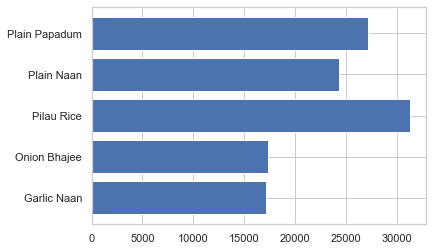

In [27]:
Ttpro = df.groupby("Item Name")["Total products"].sum()
Ttcout = df["Item Name"].value_counts()
plt.barh(y=Ttpro.index, width=Ttpro)
plt.show()

果然卖的越多总产量越多

## 看看产品数量和总价格有无关系

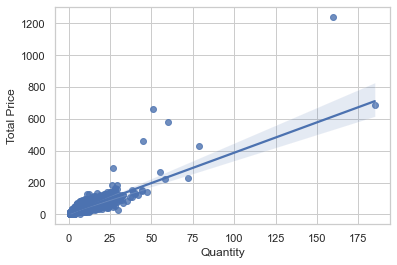

In [28]:
sns.regplot(data=order_price, x="Quantity", y="Total Price")
plt.show()

可以看到产品价格与总价格呈现线性关系，等会可以做简单的预测

# 简单的预测

## 线性回归模型预测

In [29]:
from sklearn.model_selection import train_test_split, learning_curve
from sklearn.linear_model import LinearRegression

X = order_price["Quantity"].tolist()
X = np.array(X).reshape(-1, 1)
y = order_price["Total Price"]
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.3,
                                                    random_state=0)
model = LinearRegression()
model = model.fit(X_train, y_train)
model.score(X_test, y_test)

0.6430517673102916

可见准确度有0.6，还是不错的

## 绘制学习曲线

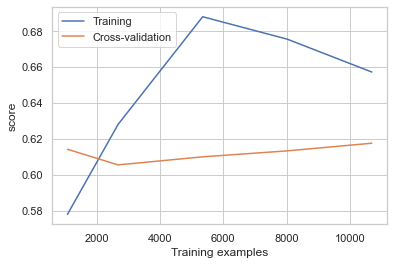

In [43]:
train_sizes, train_loss, test_loss = learning_curve(
    LinearRegression(), X, y, train_sizes=[0.1, 0.25, 0.5, 0.75, 1])
train_mean = np.mean(train_loss, axis=1)
test_mean = np.mean(test_loss, axis=1)
plt.plot(train_sizes, train_mean, label="Training")
plt.plot(train_sizes, test_mean, label="Cross-validation")
plt.xlabel("Training sizes")
plt.ylabel("score")
plt.legend()
plt.show()

可能是数据量太小的原因，效果不太理想